In [1]:
import os
import sys
import random
import warnings #
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
# Importing from tensorflow.keras instead of keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
import tensorflow as tf

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

TRAIN_PATH = '/content/drive/My Drive/U_NET/train/'
TEST_PATH = '/content/drive/My Drive/U_NET/validation/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

#### Collect file names for training and test date

In [4]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

#### Creating image masks of dimension 128 x 128 (black images)

In [5]:
print('Getting and resizing train images and masks ... ')
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)
print('Done!')

Getting and resizing train images and masks ... 
Done!


In [6]:
sys.stdout.flush()

In [7]:
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

    # Now we take all masks associated with that image and combine them into one single mask
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    # Y_train is now our single mask associated with our image
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()

# Here we resize our test images
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')



100%|██████████| 670/670 [1:08:48<00:00,  6.16s/it]

Getting and resizing test images ... 



100%|██████████| 65/65 [00:24<00:00,  2.64it/s]

Done!


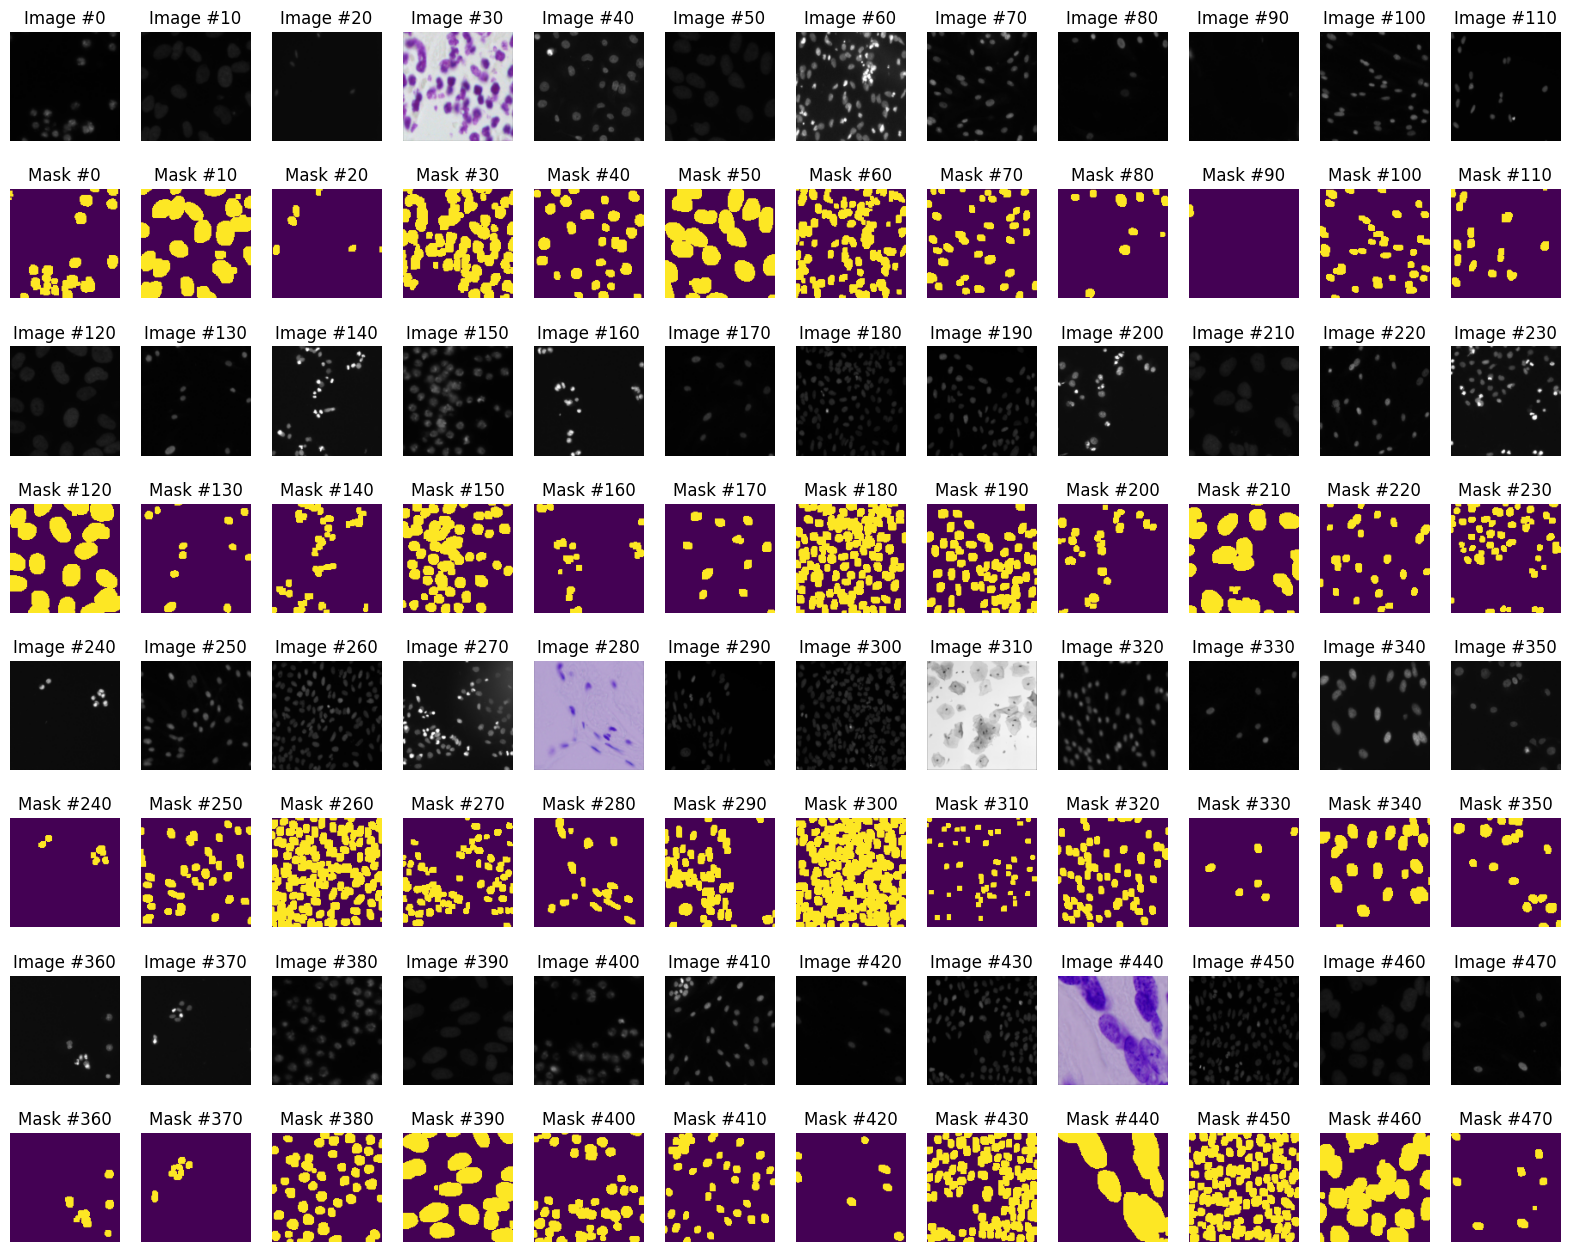

In [9]:
# Illustrate the train images and masks
plt.figure(figsize=(20,16))
x,y = 12,4
for i in range(y):
  for j in range(x):
    plt.subplot(y*2, x, i*2*x+j+1)
    pos = i*120 + j*10
    plt.imshow(X_train[pos])
    plt.title('Image #{}'.format(pos))
    plt.axis('off')
    plt.subplot(y*2, x, (i*2+1)*x+j+1)

    # We display the associated mask we just generated above with the training image
    plt.imshow(np.squeeze(Y_train[pos]))
    plt.title('Mask #{}'.format(pos))
    plt.axis('off')
plt.show()

### Define a custom Metric called Intersection over Union (IoU)

In [10]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)

    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute Union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)

    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.array(np.mean(metric), dtype = np.float32)

def my_iou_metric(label, pred):
    metric_value = tf.py_function(iou_metric_batch, [label, pred], tf.float32)
    return metric_value


### Building our U-Net Model

In [11]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255)(inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

# Note our output is efefctively a mask of 128 x 128
outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy')
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 128, 128, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 16)   │            448 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 16)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 16)   │          2,320 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 16)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 32)     │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64, 64, 32)     │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 32)     │          9,248 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 32)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 32, 32, 64)     │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 64)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 16, 16, 128)    │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 128)    │        147,584 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 8, 8, 128)      │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)       

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
print(f"X_train shape: {X_train.shape}, dtype: {X_train.dtype}")
print(f"Y_train shape: {Y_train.shape}, dtype: {Y_train.dtype}")


X_train shape: (670, 128, 128, 3), dtype: uint8
Y_train shape: (670, 128, 128, 1), dtype: bool


In [12]:
#X_train = X_train.astype(np.float32) / 255.0
#Y_train = Y_train.astype(np.float32)


### Fit our model

In [13]:
# Initialize our callbacks
model_path = "/nuclei_finder_unet_1.h5"
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', mode="min", save_best_only=True, verbose=1)

earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True)

# Fit our model
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=10, callbacks=[earlystop, checkpoint])

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.5270
Epoch 1: val_loss improved from inf to 0.20221, saving model to /nuclei_finder_unet_1.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step - loss: 0.5238 - val_loss: 0.2022
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.2063
Epoch 2: val_loss did not improve from 0.20221
38/38 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - loss: 0.2060 - val_loss: 0.3590
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.1588
Epoch 3: val_loss improved from 0.20221 to 0.14706, saving model to /nuclei_finder_unet_1.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 106s 3s/step - loss: 0.1591 - val_loss: 0.1471
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.1627
Epoch 4: val_loss improved from 0.14706 to 0.13768, saving model to /nuclei_finder_unet_1.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 138s 3s/step - loss: 0.1628 - val_loss: 0.1377
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.1532
Epoch 5: val_loss did not improve from 0.13768
38/38 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - loss: 0.1532 - val_loss: 0.1379
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.1343
Epoch 6: val_loss improved from 0.13768 to 0.13329, saving model to /nuclei_finder_unet_1.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - loss: 0.1343 - val_loss: 0.1333
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.1301
Epoch 7: val_loss improved from 0.13329 to 0.11616, saving model to /nuclei_finder_unet_1.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - loss: 0.1301 - val_loss: 0.1162
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.1290
Epoch 8: val_loss improved from 0.11616 to 0.10405, saving model to /nuclei_finder_unet_1.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - loss: 0.1288 - val_loss: 0.1040
Epoch 9/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.1139
Epoch 9: val_loss did not improve from 0.10405
38/38 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - loss: 0.1140 - val_loss: 0.1117
Epoch 10/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.1116
Epoch 10: val_loss improved from 0.10405 to 0.09589, saving model to /nuclei_finder_unet_1.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - loss: 0.1116 - val_loss: 0.0959
Restoring model weights from the end of the best epoch: 10.


In [20]:
from sklearn.model_selection import train_test_split
X_train_split, X_val, Y_train_split, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

# Predict on validation set
y_pred_val = model.predict(X_val)

# Compute IoU
iou_score = iou_metric_batch(Y_val, y_pred_val)
print("IoU Score on Validation Set:", iou_score)


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
IoU Score on Validation Set: 0.5671024


### Generating our predictions for training and validation data

In [15]:
# the first 90% was used for training
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)

# the last 10% used as validation
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

19/19 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 720ms/step


### Showing our predicted masks on our training data

<ipython-input-18-cd7ab9b24147>:7: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(X_train[ix])
<ipython-input-18-cd7ab9b24147>:12: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(np.squeeze(Y_train[ix]))
<ipython-input-18-cd7ab9b24147>:17: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(np.squeeze(preds_train_t[ix] > 0.5))


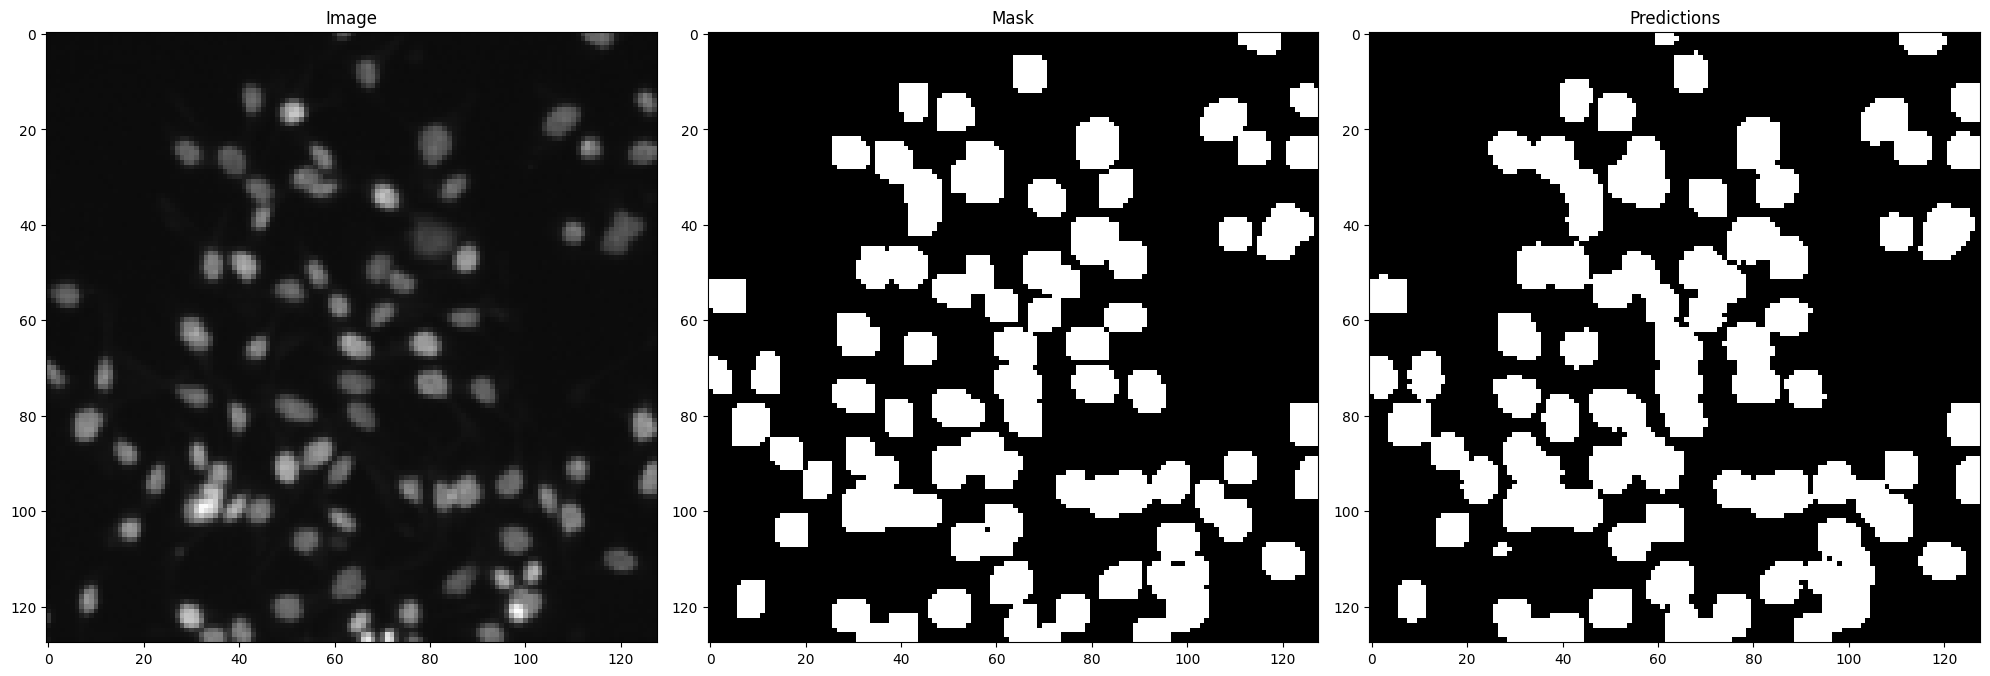

In [18]:
# Ploting our predicted masks
ix = random.randint(0, 602)
plt.figure(figsize=(20,20))

# Our original training image
plt.subplot(131)
imshow(X_train[ix])
plt.title("Image")

# Our original combined mask
plt.subplot(132)
imshow(np.squeeze(Y_train[ix]))
plt.title("Mask")

# The mask our U-Net model predicts
plt.subplot(133)
imshow(np.squeeze(preds_train_t[ix] > 0.5))
plt.title("Predictions")
plt.show()


### Showing our predicted masks on our validation data

<ipython-input-17-aa8a401c5ba5>:7: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(X_train[ix])
<ipython-input-17-aa8a401c5ba5>:13: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(np.squeeze(preds_val_t[ix] > 0.5))


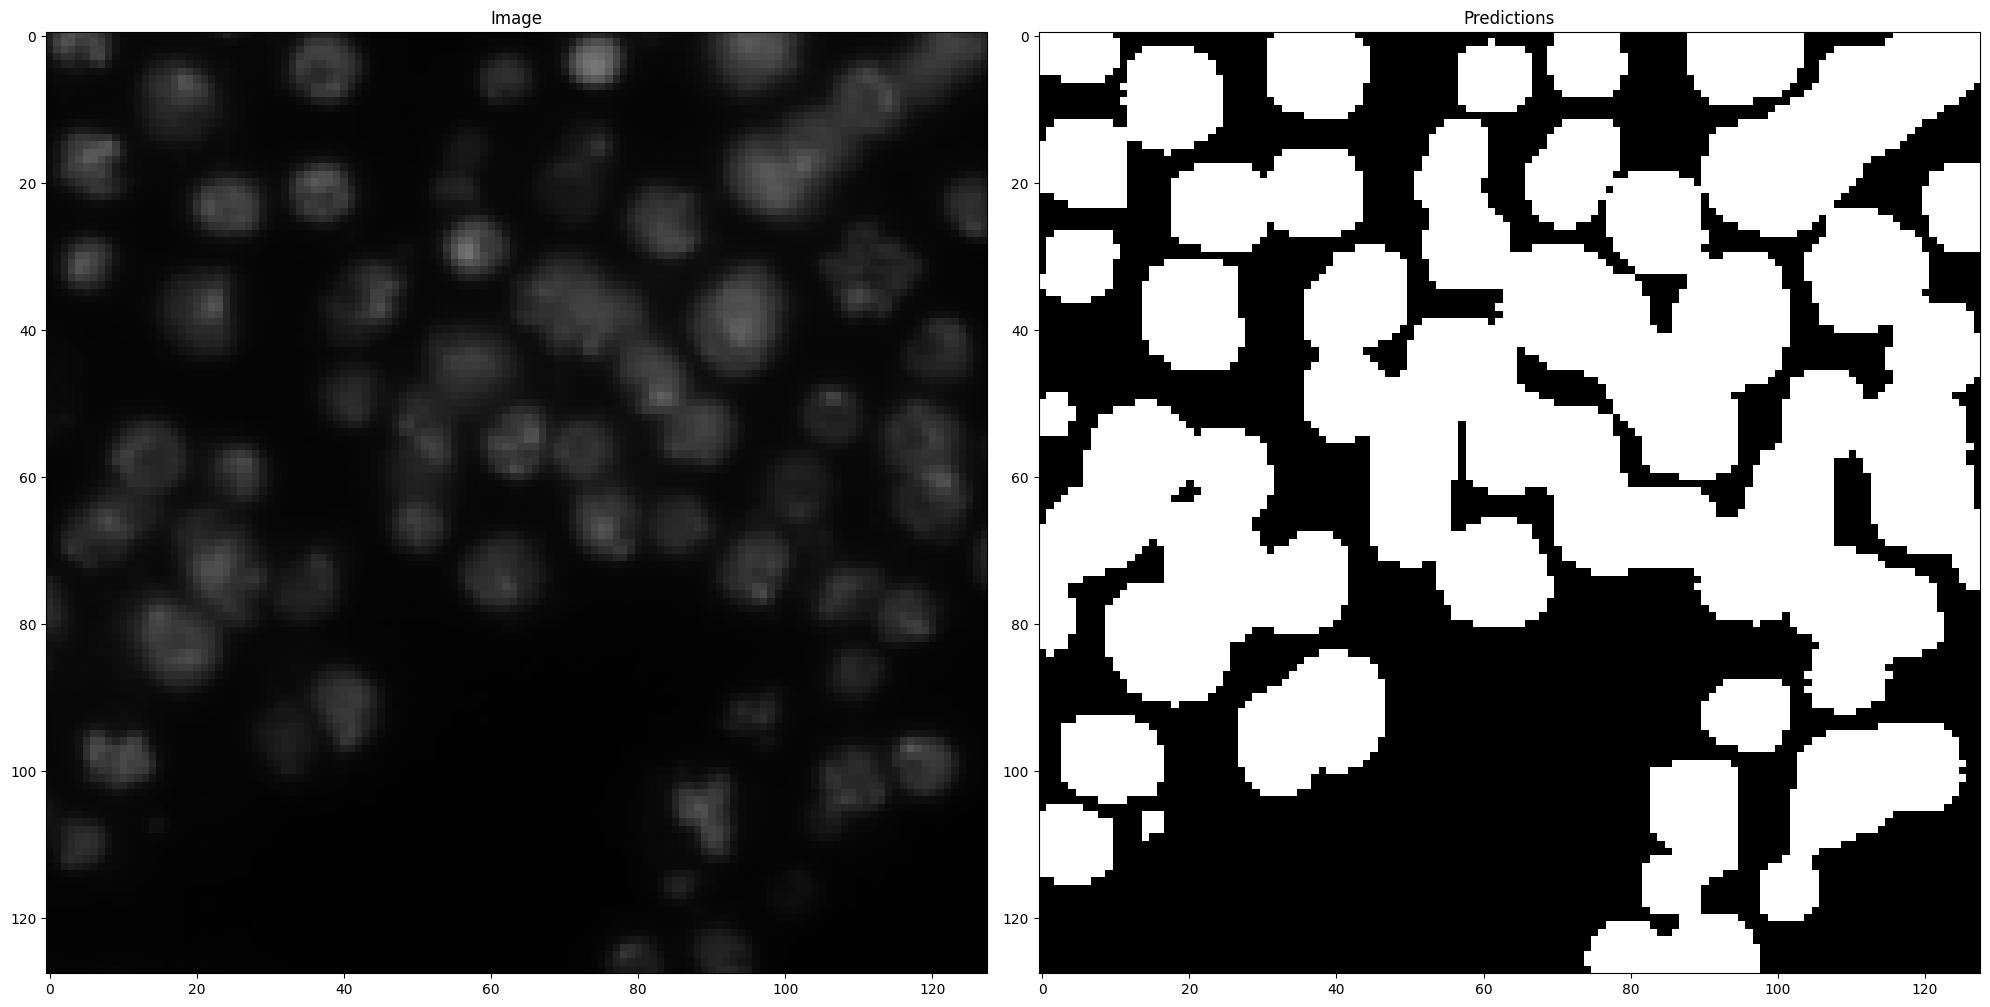

In [17]:
# Ploting our predicted masks
ix = random.randint(602, 668)
plt.figure(figsize=(20,20))

# Our original training image
plt.subplot(121)
imshow(X_train[ix])
plt.title("Image")

# The mask our U-Net model predicts
plt.subplot(122)
ix = ix - 603
imshow(np.squeeze(preds_val_t[ix] > 0.5))
plt.title("Predictions")
plt.show()